# Sectioned Fourier Shell Correlation: 80nm gold beads sample and misaligned excitation beam

In order to characterize the new resolution estimation tool, image stacks of 80nm gold beads were acquired with our custom confocal system. By imaging single point sources it was possible to cross-check the numerical results obtained with the FSC method with direct line profile measurments from the images. Here I try to estimate how tilting of the excitation beam might affect the FSC measure.

In [12]:
%matplotlib inline
from ipywidgets import interact, fixed
from scipy import ndimage

import numpy as np

import os
import supertomo.ui.frc_options as options
from supertomo.ui.plots.image import display_2d_images
from supertomo.data.io import read
import supertomo.processing.image as imops
from supertomo.analysis.resolution.fourier_shell_correlation import DirectionalFSC
from supertomo.data.containers.image import Image
import supertomo.data.iterators.fourier_shell_iterators as iterators
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.ui.plots.frc as frcplots

def show_axial_slice(image1, image2, slice):
    display_2d_images(image1[slice], image2[slice])

## Test Data

A sample of 80nm sub-resolution gold beads was imaged in our custom laser-scanning confocal microscope. The fluorescence filter was removed from the confocal detector (APD) to allow the recording of laser reflection signal. The excitation laser line was manually misaligned slightly to create a axially tilted excitation intensity profile.

Two stacks were acquired in line-by-line fashion to enable straightforward analysis with FSC.

In [13]:
# Image
data_dir = "/Users/sami/OneDrive - Fondazione Istituto Italiano Tecnologia/Microscopy/2018_04_FSC_measures_confocal"
image_name = "2018_04_19_HeLa_Tubulin_Normal_Sampling.tif"

# Get script options
args_list = [data_dir, '--bin-delta=15', '--frc-curve-fit-degree=3', 
            '--resolution-threshold-criterion=fixed', '--resolution-threshold-value=0.5',
            '--angle-delta=10', '--enable-hollow-iterator', '--extract-angle-delta=1', 
             '--resolution-point-sigma=0.001', '--debug', '--use-splines']
args = options.get_frc_script_options(args_list)

# Get image
image1 = read.get_image(os.path.join(data_dir, image_name), channel=0)
image2 = read.get_image(os.path.join(data_dir, image_name), channel=1)

# Pre-process
image1 = imops.zoom_to_isotropic_spacing(image1, order=1)
image2 = imops.zoom_to_isotropic_spacing(image2, order=1)

image1 = imops.zero_pad_to_cube(image1)
image2 = imops.zero_pad_to_cube(image2)

interact(show_axial_slice, image1=fixed(image1), image2=fixed(image2), slice=(0, image1.shape[0]-1))

The zoom is [1.967741935483871, 1.0, 1.0]
The zoom is [1.967741935483871, 1.0, 1.0]


interactive(children=(IntSlider(value=130, description=u'slice', max=261), Output()), _dom_classes=('widget-interact',))

<function __main__.show_axial_slice>

## Image registration

The two image stacks were registered for robust analysis (not very important)

Setting up registration job
Starting registration
Final metric value: -0.994990054127
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 12 iterations. Gradient magnitude (1.39677e-05) is less than gradient magnitude tolerance (0.0001).


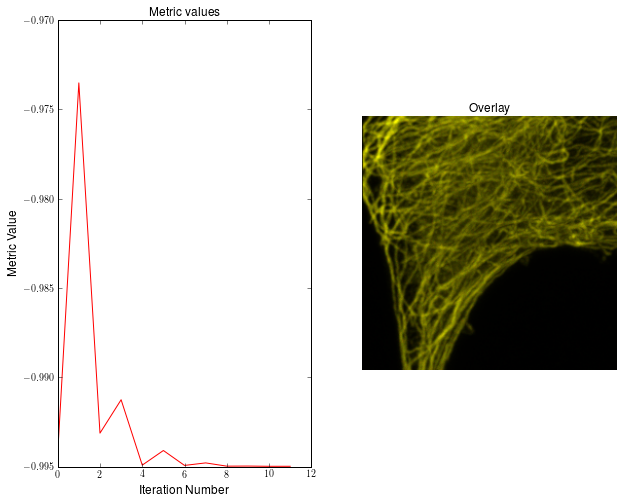

In [14]:
import SimpleITK as sitk

import supertomo.ui.supertomo_options as supertomo_options
from supertomo.processing.registration import registration
from supertomo.processing import itk

fixed_image = itk.convert_to_itk_image(image1)
moving_image = itk.convert_to_itk_image(image2)


args_list_2 = ("--sampling-percentage=.01 --reg-relax-factor=.6 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation " 
        "--reg-enable-observers").split()

registration_options = supertomo_options.get_debug_script_options(args_list_2)

transform = registration.itk_registration_rigid_3d(fixed_image, moving_image, registration_options)

image2 = itk.convert_from_itk_image(itk.resample_image(moving_image, transform))



## Iteration

The HollowConical iterator was used for all data analysis, as for some reason there are some strange correlations in the direction of the z-axis. Exclusion of a small central part of the section that is centered at 90° completely fixes this issue.

In [15]:

def calculate_fourier_correlations(image1, image2, args):
    iterator = iterators.HollowConicalFourierShellIterator(image1.shape, args.d_bin, args.d_angle, args.d_extract_angle)
    fsc_task = DirectionalFSC(image1, image2, iterator)
    return fsc_task.execute()

data = calculate_fourier_correlations(image1, image2, args)

In [16]:
#import matplotlib.pyplot as plt
#df = data.as_dataframe()
#df.groupby("Angle").plot(x='Frequency', y='Correlation')

## Results

Tilting of the excitation beam becomes visible as decrease of resolution in the direction of the tilt. The numerical results here are not accurate -- why? Maybe I should here in general comment about the iterpretation fo the results, and about it being much more interesting as a relative measure (image quality) rather than numeric resolution estimation tool.

In [17]:
analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
result = analyzer.execute()

Calculating resolution point for dataset 150
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 13
         Function evaluations: 26
Calculating resolution point for dataset 210
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 11
         Function evaluations: 22
Calculating resolution point for dataset 310
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 14
         Function evaluations: 28
Calculating resolution point for dataset 190
Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 14
         Function evaluations: 28
Calculating resolution point for dataset 60
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 13
         Function evaluations: 26
Calculating resolution point for dataset 130
Optimization terminated successfully.
   

ValueError: A value in x_new is above the interpolation range.

In [ ]:

plotter = frcplots.FourierDataPlotter(result)
plotter.plot_polar()

In [ ]:
plotter.plot_all()

In [ ]:
image1 = Image(np.transpose(image1, (0,2,1)), image1.spacing)
image2 = Image(np.transpose(image2, (0,2,1)), image2.spacing)

data2 = calculate_fourier_correlations(image1, image2, args)

analyzer = fsc_analysis.FourierCorrelationAnalysis(data2, image1.spacing[0], args)
result2 = analyzer.execute()

In [ ]:
plotter = frcplots.FourierDataPlotter(result2)
plotter.plot_polar()

In [ ]:
plotter.plot_all()